## 🎯 Objectif du notebook

Ce notebook vise à **exploiter les données Gold** à des fins de **modélisation prédictive**.  
Nous cherchons à :
- Prédire le **taux de mortalité** via une régression,
- Prédire la **disponibilité des vaccins/traitements** via une classification,
- Prédire les **DALYs** (années de vie perdues corrigées de l’incapacité),
- Évaluer les modèles (RMSE, AUC),
- Visualiser les **features les plus influentes** pour chaque prédiction.


In [1]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

# ✅ Chargement des données silver nettoyées
df_silver_clean = spark.read.table("global_health_silver").dropDuplicates()

# 🔤 Renommage des colonnes se terminant par "_"
rename_map = {col_name: col_name.rstrip("_") for col_name in df_silver_clean.columns if col_name.endswith("_")}
for old_name, new_name in rename_map.items():
    df_silver_clean = df_silver_clean.withColumnRenamed(old_name, new_name)

print("✅ Colonnes renommées")



StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 3, Finished, Available, Finished)

✅ Colonnes renommées


In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Variables explicatives
features_mortality = [
    "prevalence_rate", "incidence_rate", "recovery_rate", 
    "education_index", "per_capita_income_usd",
    "healthcare_access", "doctors_per_1000", "hospital_beds_per_1000",
    "average_treatment_cost_usd", "urbanization_rate"
]

# 2. Imputation
df_mortality = df_silver_clean
for colname in features_mortality:
    avg_val = df_mortality.selectExpr(f"avg({colname}) as avg").collect()[0]["avg"]
    df_mortality = df_mortality.na.fill({colname: avg_val})

# 3. Vectorisation + mise à l’échelle
assembler_mortality = VectorAssembler(inputCols=features_mortality, outputCol="features_assembled")
scaler_mortality = StandardScaler(inputCol="features_assembled", outputCol="features")

# 4. Modèle GBT
gbt_mortality = GBTRegressor(featuresCol="features", labelCol="mortality_rate", maxDepth=5, maxIter=50)

pipeline_mortality = Pipeline(stages=[assembler_mortality, scaler_mortality, gbt_mortality])

# 5. Split et entraînement
train_mortality, test_mortality = df_mortality.randomSplit([0.8, 0.2], seed=42)
model_mortality = pipeline_mortality.fit(train_mortality)

# 6. Prédictions
predictions_mortality = model_mortality.transform(test_mortality)

# 7. Évaluation
evaluator = RegressionEvaluator(labelCol="mortality_rate", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_mortality)
print(f"✅ RMSE sur mortality_rate : {rmse:.2f}")


StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 4, Finished, Available, Finished)

✅ RMSE sur mortality_rate : 2.86


In [3]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when

# 1. Conversion Yes/No → 1/0
df_vaccine = df_silver_clean.withColumn(
    "vaccine_binary",
    when(col("availability_of_vaccinestreatment") == "Yes", 1).otherwise(0)
)

# 2. Features
features_vaccine = [
    "prevalence_rate", "incidence_rate", "mortality_rate",
    "education_index", "per_capita_income_usd",
    "healthcare_access", "doctors_per_1000", "hospital_beds_per_1000",
    "average_treatment_cost_usd", "urbanization_rate"
]

for colname in features_vaccine:
    avg_val = df_vaccine.selectExpr(f"avg({colname}) as avg").collect()[0]["avg"]
    df_vaccine = df_vaccine.na.fill({colname: avg_val})

assembler_vaccine = VectorAssembler(inputCols=features_vaccine, outputCol="features_assembled")
scaler_vaccine = StandardScaler(inputCol="features_assembled", outputCol="features")

gbt_vaccine = GBTClassifier(featuresCol="features", labelCol="vaccine_binary", maxDepth=5, maxIter=50)

pipeline_vaccine = Pipeline(stages=[assembler_vaccine, scaler_vaccine, gbt_vaccine])

train_vaccine, test_vaccine = df_vaccine.randomSplit([0.8, 0.2], seed=42)
model_vaccine = pipeline_vaccine.fit(train_vaccine)

predictions_vaccine = model_vaccine.transform(test_vaccine)

evaluator = BinaryClassificationEvaluator(labelCol="vaccine_binary")
auc = evaluator.evaluate(predictions_vaccine)
print(f"✅ AUC sur la prédiction vaccine : {auc:.2f}")


StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 5, Finished, Available, Finished)

✅ AUC sur la prédiction vaccine : 0.54


In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# 1. Préparation des données
print("📦 Préparation des données pour la prédiction de DALYs")

df_dalys = df_silver_clean.filter((col("dalys").isNotNull()) & (col("dalys") < 5000))

# Sous-échantillon (pour test rapide)
#df_sample = df_dalys.sample(fraction=0.1, seed=42)

df_sample = df_dalys

# Sélection des colonnes pertinentes
features_cols = [
    "prevalence_rate", "incidence_rate", "mortality_rate",
    "per_capita_income_usd", "education_index", "healthcare_access",
    "doctors_per_1000", "hospital_beds_per_1000", "recovery_rate",
    "average_treatment_cost_usd", "urbanization_rate"
]

# 2. Assemblage des features
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# 3. Modèle
gbt_dalys = GBTRegressor(labelCol="dalys", featuresCol="features", maxIter=30)

# 4. Pipeline et entraînement
pipeline = Pipeline(stages=[assembler, gbt_dalys])
model_dalys = pipeline.fit(df_sample)

# 5. Prédictions
predictions = model_dalys.transform(df_sample)
predictions.select("dalys", "prediction").show(5)

# 6. Évaluation
evaluator = RegressionEvaluator(labelCol="dalys", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"✅ RMSE (Root Mean Squared Error) sur échantillon : {rmse:.2f}")

# 7. 🎯 Feature importance
importances = model_dalys.stages[-1].featureImportances
features_importance = list(zip(features_cols, importances))
features_importance_sorted = sorted(features_importance, key=lambda x: x[1], reverse=True)

print("\n🔥 Importance des features pour DALYs (ordre décroissant) :")
for feature, score in features_importance_sorted:
    print(f"{feature}: {score:.4f}")


StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 6, Finished, Available, Finished)

📦 Préparation des données pour la prédiction de DALYs


+-----+------------------+
|dalys|        prediction|
+-----+------------------+
| 2852|2490.5828005712633|
|  832|2486.6738584890177|
| 1654|2520.5818141914074|
| 1268|2471.3605612602623|
| 3696|2458.8973845667438|
+-----+------------------+
only showing top 5 rows

✅ RMSE (Root Mean Squared Error) sur échantillon : 1442.14

🔥 Importance des features pour DALYs (ordre décroissant) :
mortality_rate: 0.1026
education_index: 0.0986
prevalence_rate: 0.0973
healthcare_access: 0.0954
doctors_per_1000: 0.0928
recovery_rate: 0.0922
hospital_beds_per_1000: 0.0908
incidence_rate: 0.0901
average_treatment_cost_usd: 0.0885
urbanization_rate: 0.0762
per_capita_income_usd: 0.0754


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def plot_feature_importances(model, feature_names, top_n=10, title=""):
    # Extraire l'étape GBT (le dernier stage)
    gbt_stage = model.stages[-1]
    importances = gbt_stage.featureImportances.toArray()

    # Créer un DataFrame
    fi_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(top_n)

    # Affichage
    plt.figure(figsize=(10, 6))
    sns.barplot(data=fi_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Top {top_n} Features - {title}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 7, Finished, Available, Finished)

StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 8, Finished, Available, Finished)

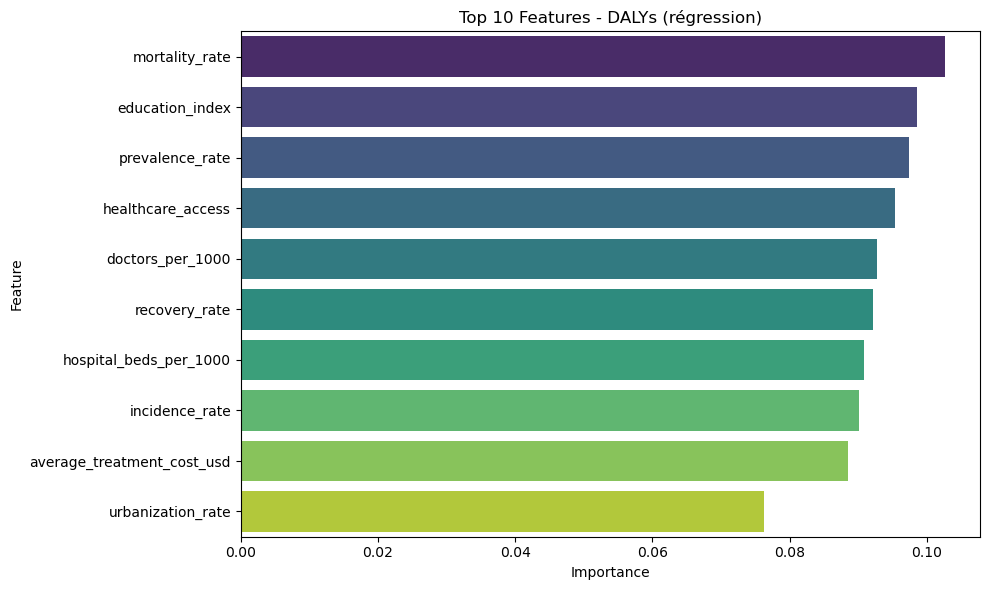

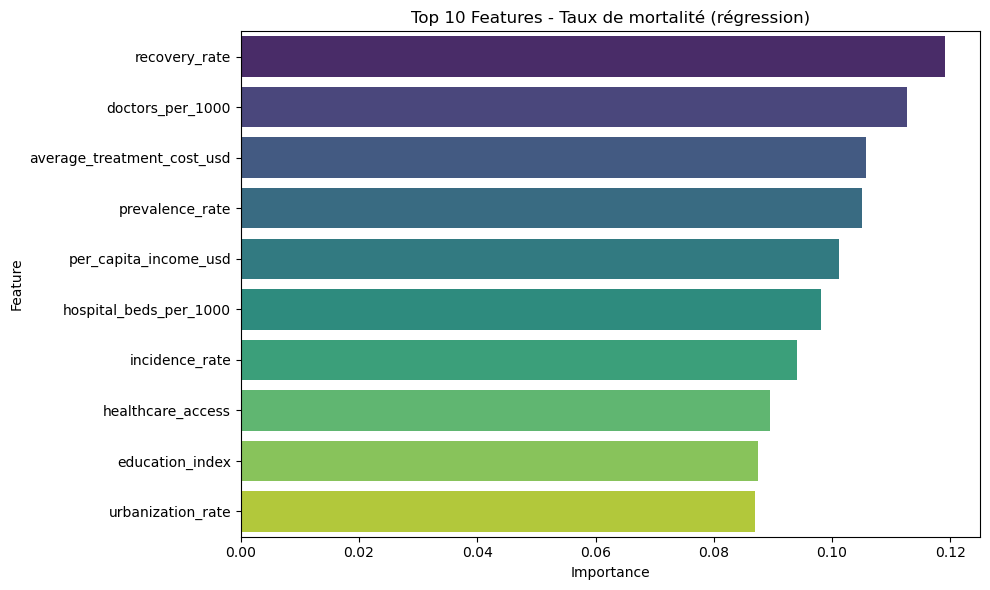

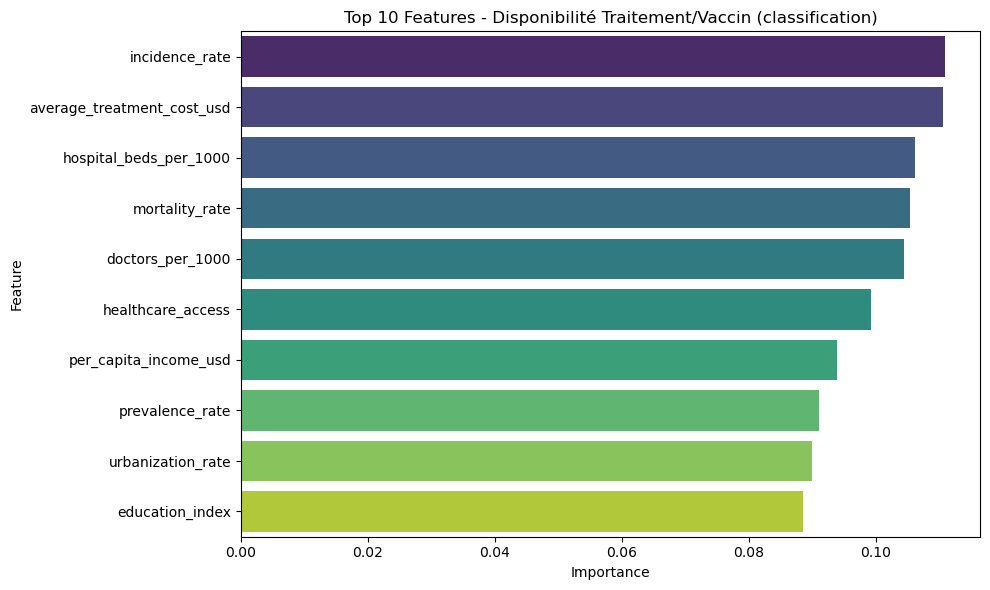

In [6]:
# DALYs
plot_feature_importances(model_dalys, features_cols, top_n=10, title="DALYs (régression)")

# Mortality Rate
plot_feature_importances(model_mortality, features_mortality, top_n=10, title="Taux de mortalité (régression)")

# Disponibilité du traitement
plot_feature_importances(model_vaccine, features_vaccine, top_n=10, title="Disponibilité Traitement/Vaccin (classification)")


In [7]:
# Répartition des classes (Yes / No)
df_silver_clean.groupBy("availability_of_vaccinestreatment").count().show()

# Pourcentage
total = df_silver_clean.count()
df_silver_clean.groupBy("availability_of_vaccinestreatment").count().withColumn(
    "pct", (col("count") / total * 100).cast("decimal(5,2)")
).show()


StatementMeta(, 16d0c7da-a339-4a4e-969f-39945a995691, 9, Finished, Available, Finished)

+---------------------------------+------+
|availability_of_vaccinestreatment| count|
+---------------------------------+------+
|                               No|499646|
|                              Yes|500354|
+---------------------------------+------+

+---------------------------------+------+-----+
|availability_of_vaccinestreatment| count|  pct|
+---------------------------------+------+-----+
|                               No|499646|49.96|
|                              Yes|500354|50.04|
+---------------------------------+------+-----+

